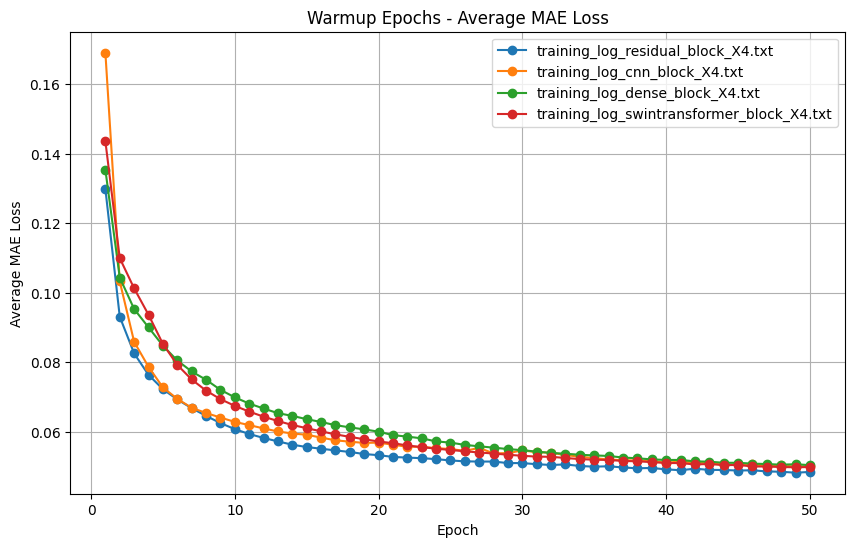

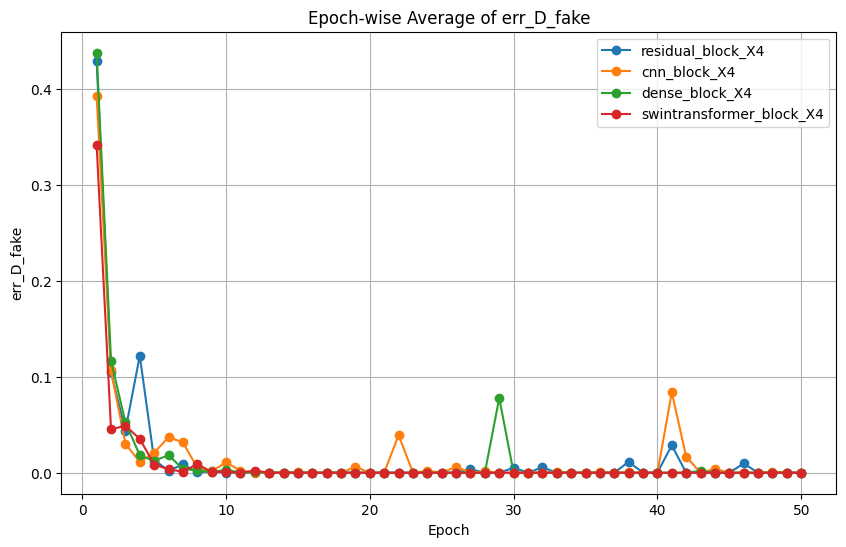

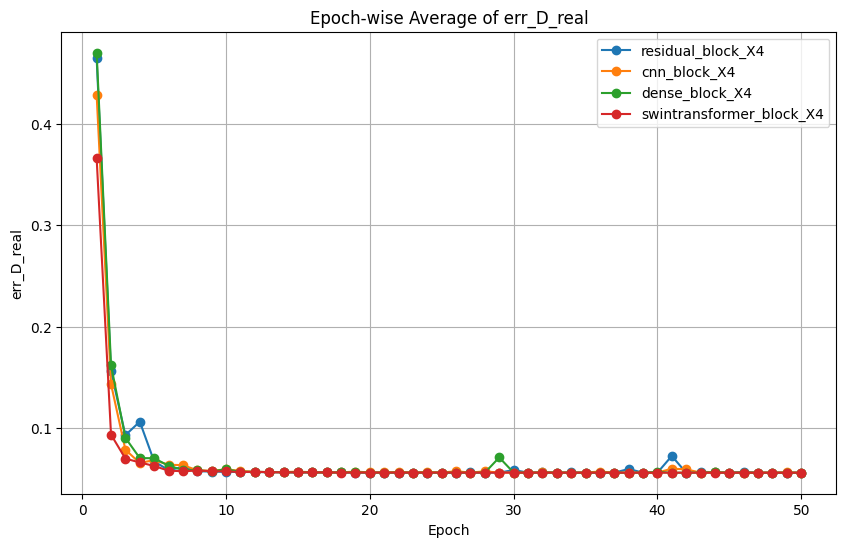

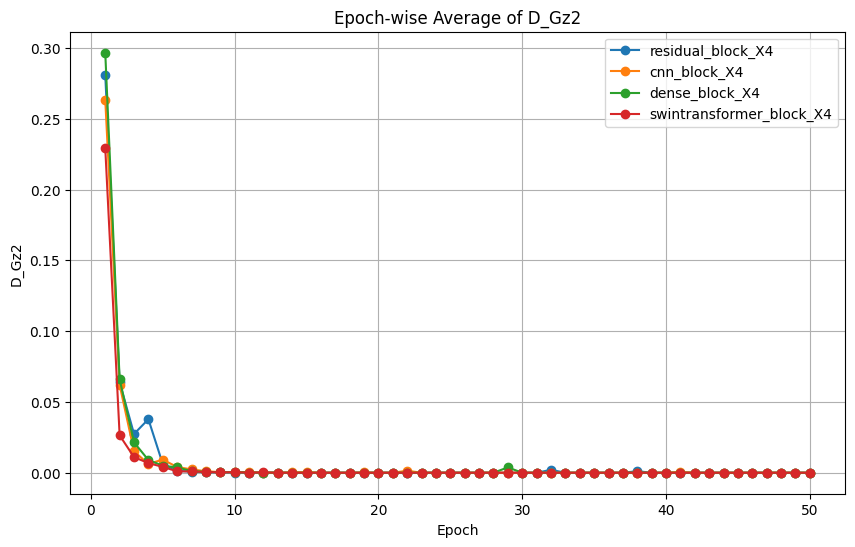

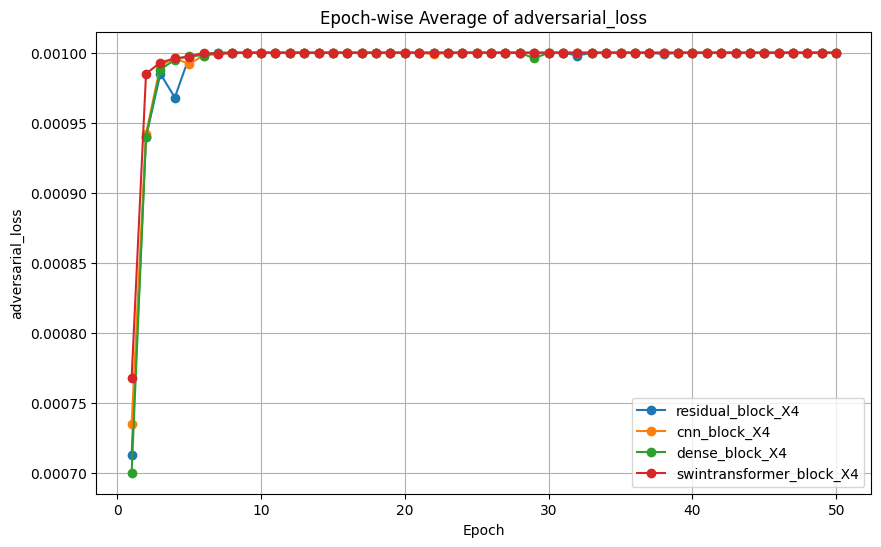

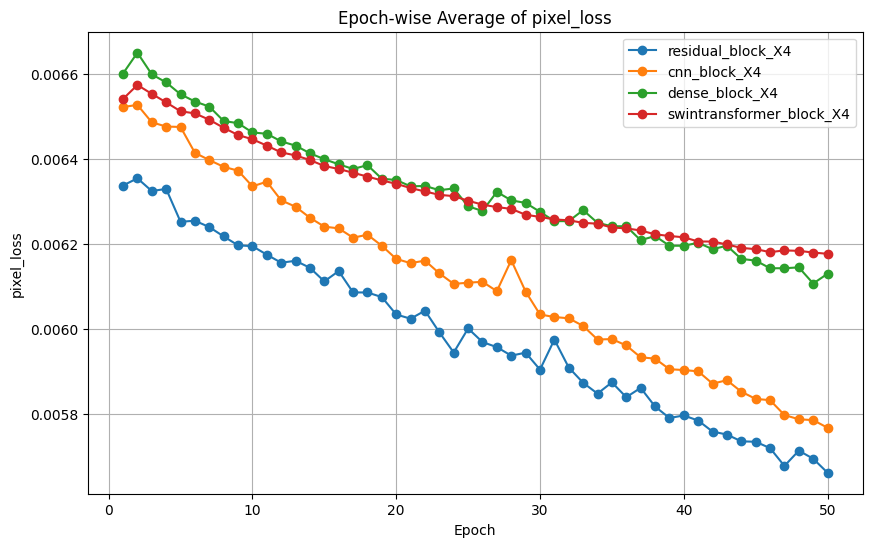

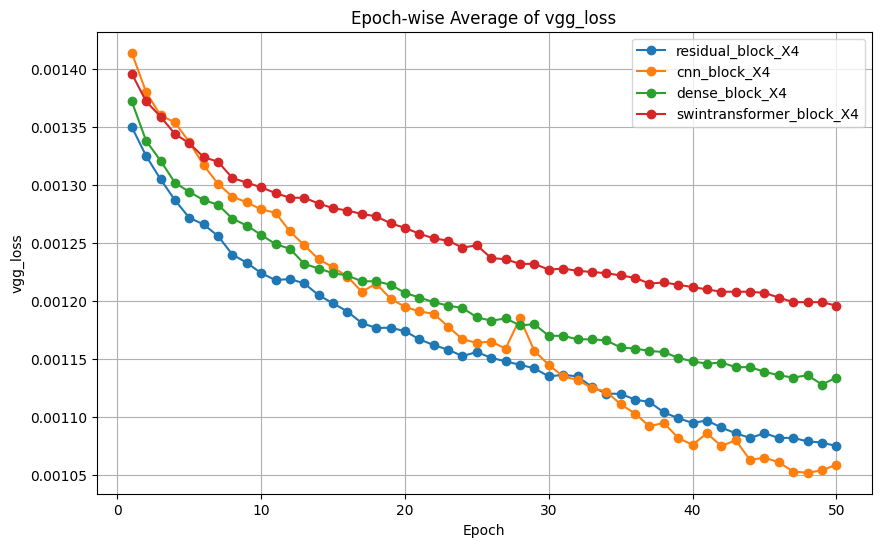

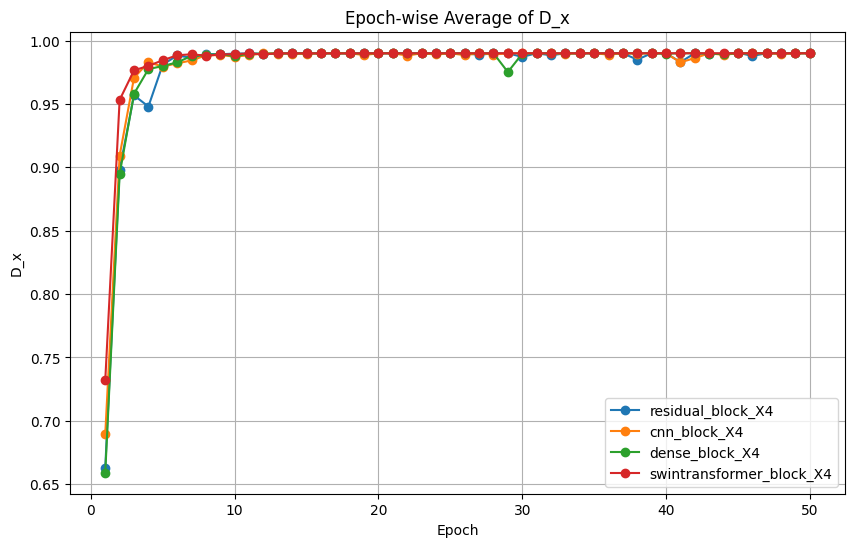

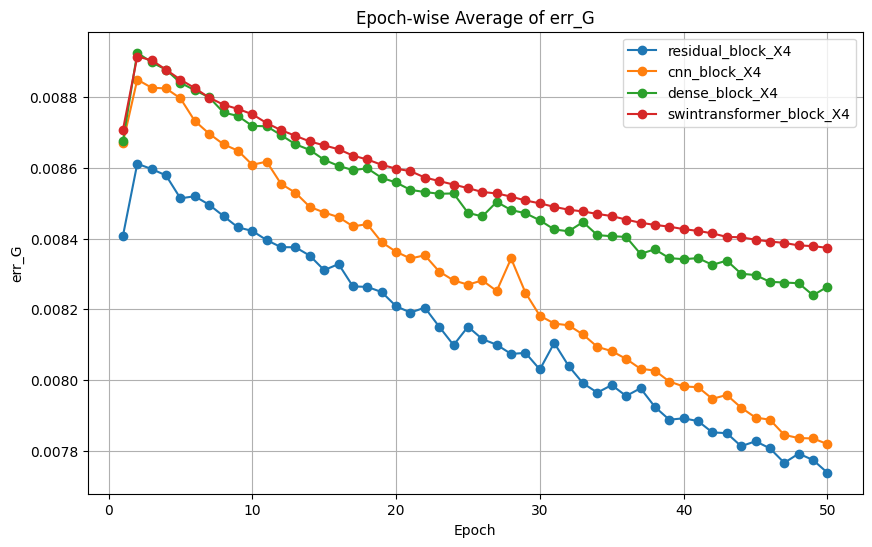

In [3]:
import re
import matplotlib.pyplot as plt
import sys
from pathlib import Path

log_files = [
    "training_log_residual_block_X4.txt",
    "training_log_cnn_block_X4.txt",
    "training_log_dense_block_X4.txt",
    "training_log_swintransformer_block_X4.txt"
]
notebook_dir = Path.cwd() 
project_root = notebook_dir.parent
sys.path.append(str(project_root))

all_warmup_data = {}
all_training_data = {}

for log_file_name in log_files:
    log_file = project_root / "logs" / log_file_name
    if log_file.exists():
        with open(log_file, 'r') as file:
            log_data = file.readlines()
    else:
        print(f"Log file not found: {log_file}")
        continue
    
    warmup_epochs = {}
    training_epochs = {}
    for line in log_data:
        line = line.strip()
        warmup_match = re.match(r'Warmup Epoch (\d+), Batch (\d+): MAE Loss = ([\d\.]+)', line)
        if warmup_match:
            epoch = int(warmup_match.group(1))
            mae_loss = float(warmup_match.group(3))
            if epoch not in warmup_epochs:
                warmup_epochs[epoch] = []
            warmup_epochs[epoch].append(mae_loss)
        else:
            training_match = re.match(r'Epoch (\d+), Batch (\d+): (.+)', line)
            if training_match:
                epoch = int(training_match.group(1))
                metrics_str = training_match.group(3)
                metrics = {}
                for metric in metrics_str.split(', '):
                    key_value = metric.strip().split(' = ')
                    if len(key_value) == 2:
                        key, value = key_value
                        try:
                            metrics[key] = float(value)
                        except ValueError:
                            pass
                if epoch not in training_epochs:
                    training_epochs[epoch] = {}
                for key, value in metrics.items():
                    if key not in training_epochs[epoch]:
                        training_epochs[epoch][key] = []
                    training_epochs[epoch][key].append(value)

    warmup_avg = {epoch: sum(losses) / len(losses) for epoch, losses in warmup_epochs.items()}
    training_avg = {epoch: {key: sum(values) / len(values) for key, values in metrics.items()}
                    for epoch, metrics in training_epochs.items()}
    

    all_warmup_data[log_file_name] = warmup_avg
    all_training_data[log_file_name] = training_avg

plt.figure(figsize=(10, 6))
for file_name, warmup_avg in all_warmup_data.items():
    plt.plot(list(warmup_avg.keys()), list(warmup_avg.values()), marker='o', label=file_name.replace("training_log_", "").replace(".txt", ""))
plt.title('Warmup Epochs - Average MAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Average MAE Loss')
plt.grid(True)
plt.legend()
plt.show()

all_metrics = set()
for training_avg in all_training_data.values():
    for metrics in training_avg.values():
        all_metrics.update(metrics.keys())

for metric_name in all_metrics:
    plt.figure(figsize=(10, 6))
    for file_name, training_avg in all_training_data.items():
        x_epochs = list(training_avg.keys())
        y_values = [training_avg[epoch][metric_name] for epoch in x_epochs if metric_name in training_avg[epoch]]
        plt.plot(x_epochs, y_values, marker='o', label=file_name.replace("training_log_", "").replace(".txt", ""))
    plt.title(f'Epoch-wise Average of {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.legend()
    plt.show()
